# Project 2: Bipartite Graphs and Projections
By Shyam Balagurumurthy and Latif Masud

# Introduction

For this project, we chose to look at a dataset of flights airports and airline routes. The dataset was taken from [OpenFlights](https://openflights.org/data.html) containing airports, routes, and airline information. Using this dataset, we built out networkX bipartite graphs and performed graph projections.

## Loading the Dataset

Below are the libraries we needed for the project. `networkx`, `matplotlib`, `geo`, and `operator` are all used for creating a bipartite graph, while `basemap` is used for map visualization. With these libraries we have created a bipartite graph using source and destination. 

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

from operator import itemgetter
import geopy.distance as geo

Original dataset contains source, destinations, airlines and lat/log. With these informations we have created a weighted graph by calculating the distance between two locations. After creating the dataset we have added the airlines as the edge attributes. So by adding these additional attributes, we can find the miniumum/maximum distance aiports and perform island filters based on the distance attributes. 

In [11]:
def clean_str(line):
    invalids = ['"', '\n']
    for n in invalids:
        line = line.replace(n, '')
        
    return line

def extract_data(file_loc, props):
    # Read in file
    file_obj = open(file_loc, "r",encoding="utf8")
    lines = file_obj.readlines()
    file_obj.close()
    

    #Takes the lines that were read in, does a split to create an array, then zips
    #with the props to create a 2d array, and then forms a dictionary from that 2d array,
    #and returns a list of those dictionaries.
    return list(map(lambda x: dict(zip(props, clean_str(x).split(","))), lines))

def show_graph(G):
    color_map = {'airline': "#117A65",
             'route': "#E67E22",
             'source': "#1aff1a",
             'destination': "#ff0000"  
            }

    nx.draw(G, node_color=[color_map[G.node[node]['node_type']] for node in G], with_labels=True)
    plt.show()

In [12]:
airport_props = [
        "airport_id",
        "name",
        "city",
        "country",
        "iata",
        "icao",
        "lat",
        "lon",
        "altitude",
        "timezone",
        "dst",
        "tz_database_time_zone",
        "type",
        "source"
]

route_props = [
        "airline",
        "airline_id",
        "source_airport",
        "source_airport_id",
        "destination_airport",
        "destination_airport_id",
        "codeshare",
        "stops",
        "equipment"
        ]

airlines_props = [
    "airline_id",
    "name",
    "alias",
    "iata",
    "icao",
    "callsign",
    "country",
    "active"
]

In [13]:
routes = extract_data("./data/routes.dat", route_props)
airlines = extract_data('./data/airlines.dat',airlines_props)
airports = extract_data('./data/airports.dat',airport_props)

## Bipartite Graph of Airlines and Routes

For the first analysis, we are going to build a set of relationships between routes flown by air carriers in the United States, and the routes that they fly. This graph would be useful to find out which route is flown by which airlines or which airlines flies which routes:

In [14]:
G= nx.Graph()

In [15]:
#Transform list of airports into map of airports:
airport_map = {}
for airport in airports:
    airport_map[airport['iata']] = airport

In [16]:
#Transform list of airlines into a map of jus US airline carriers
us_carriers = {}
for airline in airlines:
    if (airline['country'] == 'United States'):
        us_carriers[airline['iata']] = airline
        G.add_node(airline['iata'], node_type='airline')

In [17]:
for route in routes:
    if (route['airline'] in us_carriers) and \
       (route['source_airport'] in airport_map) and \
       (route['destination_airport'] in airport_map):
        route_id = route['source_airport']+'->'+route['destination_airport']
        G.add_node(route_id, node_type='route', info=route)
        G.add_edge(route_id, route['airline'])
        

Now that we have the graph build out, lets look at a few examples. We'll start with finding all the airlines that fly from Los Angeles International (LAX) to John F. Kenney International (JFK). We see that with a small bit of code, we can find all the airlines that fly that route:

In [18]:
[us_carriers[iata]['name'] for iata in list(G['LAX->JFK'])]

['American Airlines',
 'JetBlue Airways',
 'Delta Air Lines',
 'United Airlines',
 'US Airways',
 'Virgin America']

We can perform the reverse as well where we can find all the routes flown by a particular airlines. In this example, we will look at all the routes flown by Allegiant Air, which has the IATA code of 'G4':

In [19]:
list(G['G4'])[:20]

['ABE->MYR',
 'ABE->PGD',
 'ABE->PIE',
 'ABE->SFB',
 'ATW->AZA',
 'ATW->LAS',
 'ATW->SFB',
 'AUS->LAS',
 'AVL->FLL',
 'AVL->PGD',
 'AVL->PIE',
 'AVL->SFB',
 'AVP->SFB',
 'AZA->ATW',
 'AZA->BIL',
 'AZA->BIS',
 'AZA->BLI',
 'AZA->BZN',
 'AZA->CID',
 'AZA->DLH']

We can also find the airline with the most routes, and the route with the most options:

In [36]:
def most_neighbors(G, node_type):
    """This function will search for the most number of neighbors using the node type"""
    node_list = []
    for n in G.nodes():
        if G.node[n]['node_type'] == node_type:
            node_list.append(n)
            
    largest_found = {
        'num_of_neighbors': -1,
        'key': ""
    }
    for node in node_list:
        if len(G[node]) > largest_found['num_of_neighbors']:
            largest_found = {'num_of_neighbors': len(G[node]), 'key': node}

    return largest_found

We see that American Airlines has the most routes of my any US carrier wtih 2354 routes.

In [21]:
most_neighbors(G, 'airline')

{'key': 'AA', 'num_of_neighbors': 2336}

And we see that the route with the most options is from Los Angeles to Las Vegas with nine flight options:

In [22]:
most_options_route = most_neighbors(G, 'route')
most_options_route

{'key': 'LAS->LAX', 'num_of_neighbors': 9}

We can access our bipartite graph again to find out what those airlines are:

In [23]:
[us_carriers[iata]['name'] for iata in list(G[most_options_route['key']])]

['Boutique Air (Priv)',
 'American Airlines',
 'Delta Air Lines',
 'AirTran Airways',
 'Spirit Airlines',
 'United Airlines',
 'US Airways',
 'Virgin America',
 'Southwest Airlines']

## Bipartite of Weighted Routes

For this part, we will calculate the distances for all the routes that US carriers fly.

In [24]:
def filter_nodes_by_type(G, node_type):
    node_list = []
    for n in G.nodes():
        if G.node[n]['node_type'] == node_type:
            node_list.append(n)
        
    return node_list

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

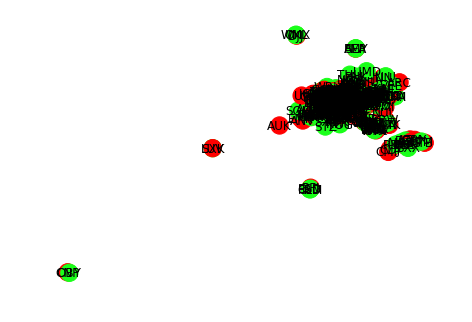

In [25]:
all_routes = filter_nodes_by_type(G, 'route')

W = nx.Graph()
for route in all_routes:
    source_iata, dest_iata = route.split("->", 1)
    
    #Calculate great circle distance between two airports:
    #the try is in here because some airports do not exist in the datbase.

    source_geo= (itemgetter('lat', 'lon')(airport_map[source_iata]))
    dest_geo= (itemgetter('lat', 'lon')(airport_map[dest_iata]))

    distance = geo.great_circle(source_geo, dest_geo).miles

    #add them to the graph with weight:
    W.add_node(source_iata, node_type='source')
    W.add_node(dest_iata, node_type='destination')
    W.add_edge(source_iata,dest_iata,weight=distance)

    
show_graph(W)

We can now use this information to find out types of analytics such as shortest flight and longest flight flown by a carrier:

In [34]:
sorted_by_distance = sorted(W.edges(data=True), key=lambda (source,target,data): data['weight'])

SyntaxError: invalid syntax (<ipython-input-34-1d376543aef1>, line 1)

In [31]:
def get_route_info(flight):
    iata = list(G[flight[1]+"->"+flight[0]])[0]
    return {"source_airport": airport_map[flight[0]]['name'], \
           "dest_airport": airport_map[flight[1]]['name'], \
           "airline": us_carriers[iata]['name'],
           "distance": flight[2]['weight']
          }

#### Shortest Flight
We find that the shortest flight in the US, actually originates and terminates at the same airport:

In [33]:
print get_route_info(sorted_by_distance[0])

NameError: name 'sorted_by_distance' is not defined

To find the first flight that actually goes to a different destination than its source airprot, we look at the second shortest flight in the United States in terms of Great Circle distance is between the two airports below, with a distance of just 6.4 miles:

In [ ]:
print get_route_info(sorted_by_distance[1])

#### Longest Flight
Now, we see that the longest direct flight offered by a US carrier is between Dallas and Sydney by American Airlienes with a whopping distance of 8582 miles!

In [ ]:
print get_route_info(sorted_by_distance[-1])

# Summary

From the above analysis, we were able to create a bipartite graph using source, destination and airlines. Also we were able to find the shortest and longest distance location, airlines and distance.